In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
band = 'J'

In [3]:
# Load in data
tbl = pd.read_csv('preprocessed_data_avg.csv')
tbl = tbl[tbl['Filter']==band] 

# load in new nH's 
new_nh = pd.read_csv('FSRED Mags - different_nH.csv')



In [4]:
def calc_L(nH, band, mag_cal, d):
    # Calculate the optical extinction from the hydrogen column density
    Av = nH / (1.79*10**(21))

    # Translate visual extinction to infrared extinction in the used filter
    if band == 'J':
        A = 0.282 * Av
    elif band == 'H':
        A = 0.175 * Av
    elif band == 'Ks':
        A = 0.112 * Av

    # Deredden the calibrated magnitudes of all detected counterparts
    mag_dered = mag_cal - A
    
    
    # Calculate flux density 
    if band == 'J':
        W_eff = 2214.62 # A
        l_eff = 12287.26 # A
    elif band == 'H':
        W_eff = 2769.45 # A 
        l_eff = 16039.55 # A
    elif band == 'Ks':
        W_eff = 3163.40 # A
        l_eff = 21315.89 # A

    c = 2.9979e18 # A/s
    F_nu = 10**(-(mag_dered+48.60)/2.5) # erg/s/cm2/Hz   
    F_lamb = F_nu * c / l_eff**2 # erg/s/cm2/A
    Flux = W_eff * F_lamb 
    
    d_cm = 3.08567758128e21 * float(d) 
    L = 4 * np.pi * d_cm**2 * Flux
    logL = np.log10(L)
    
    return L, logL

In [5]:
# for index, row in tbl.iterrows():

#     if row['Source'] in new_nh['Source'].tolist():
#         print(row['Source'])
#         print(row['log_L_NIR'])

#         mag_cal = row['Mag_raw'] - row['zp_offset']
# #         nH = row['nH'] 
#         L_old = row['log_L_NIR']
#         nH = new_nh[new_nh['Source'] == row['Source']]['nH'].values[0] * 1e22
#         d = row['Distance (kpc)']
#         L, logL = calc_L(nH, band, mag_cal, d)
#         print(logL)
#         row['log_L_NIR'] = logL
# #         tbl[n, 'log_L_NIR'] = logL
#         tbl['log_L_NIR'] = tbl['log_L_NIR'].replace([L_old], logL)
#         print(row['log_L_NIR'])
#         print()
        
# print(tbl[tbl['Source']=='2S_0918-549']['log_L_NIR'])


C:\Users\Iris Reitsma\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


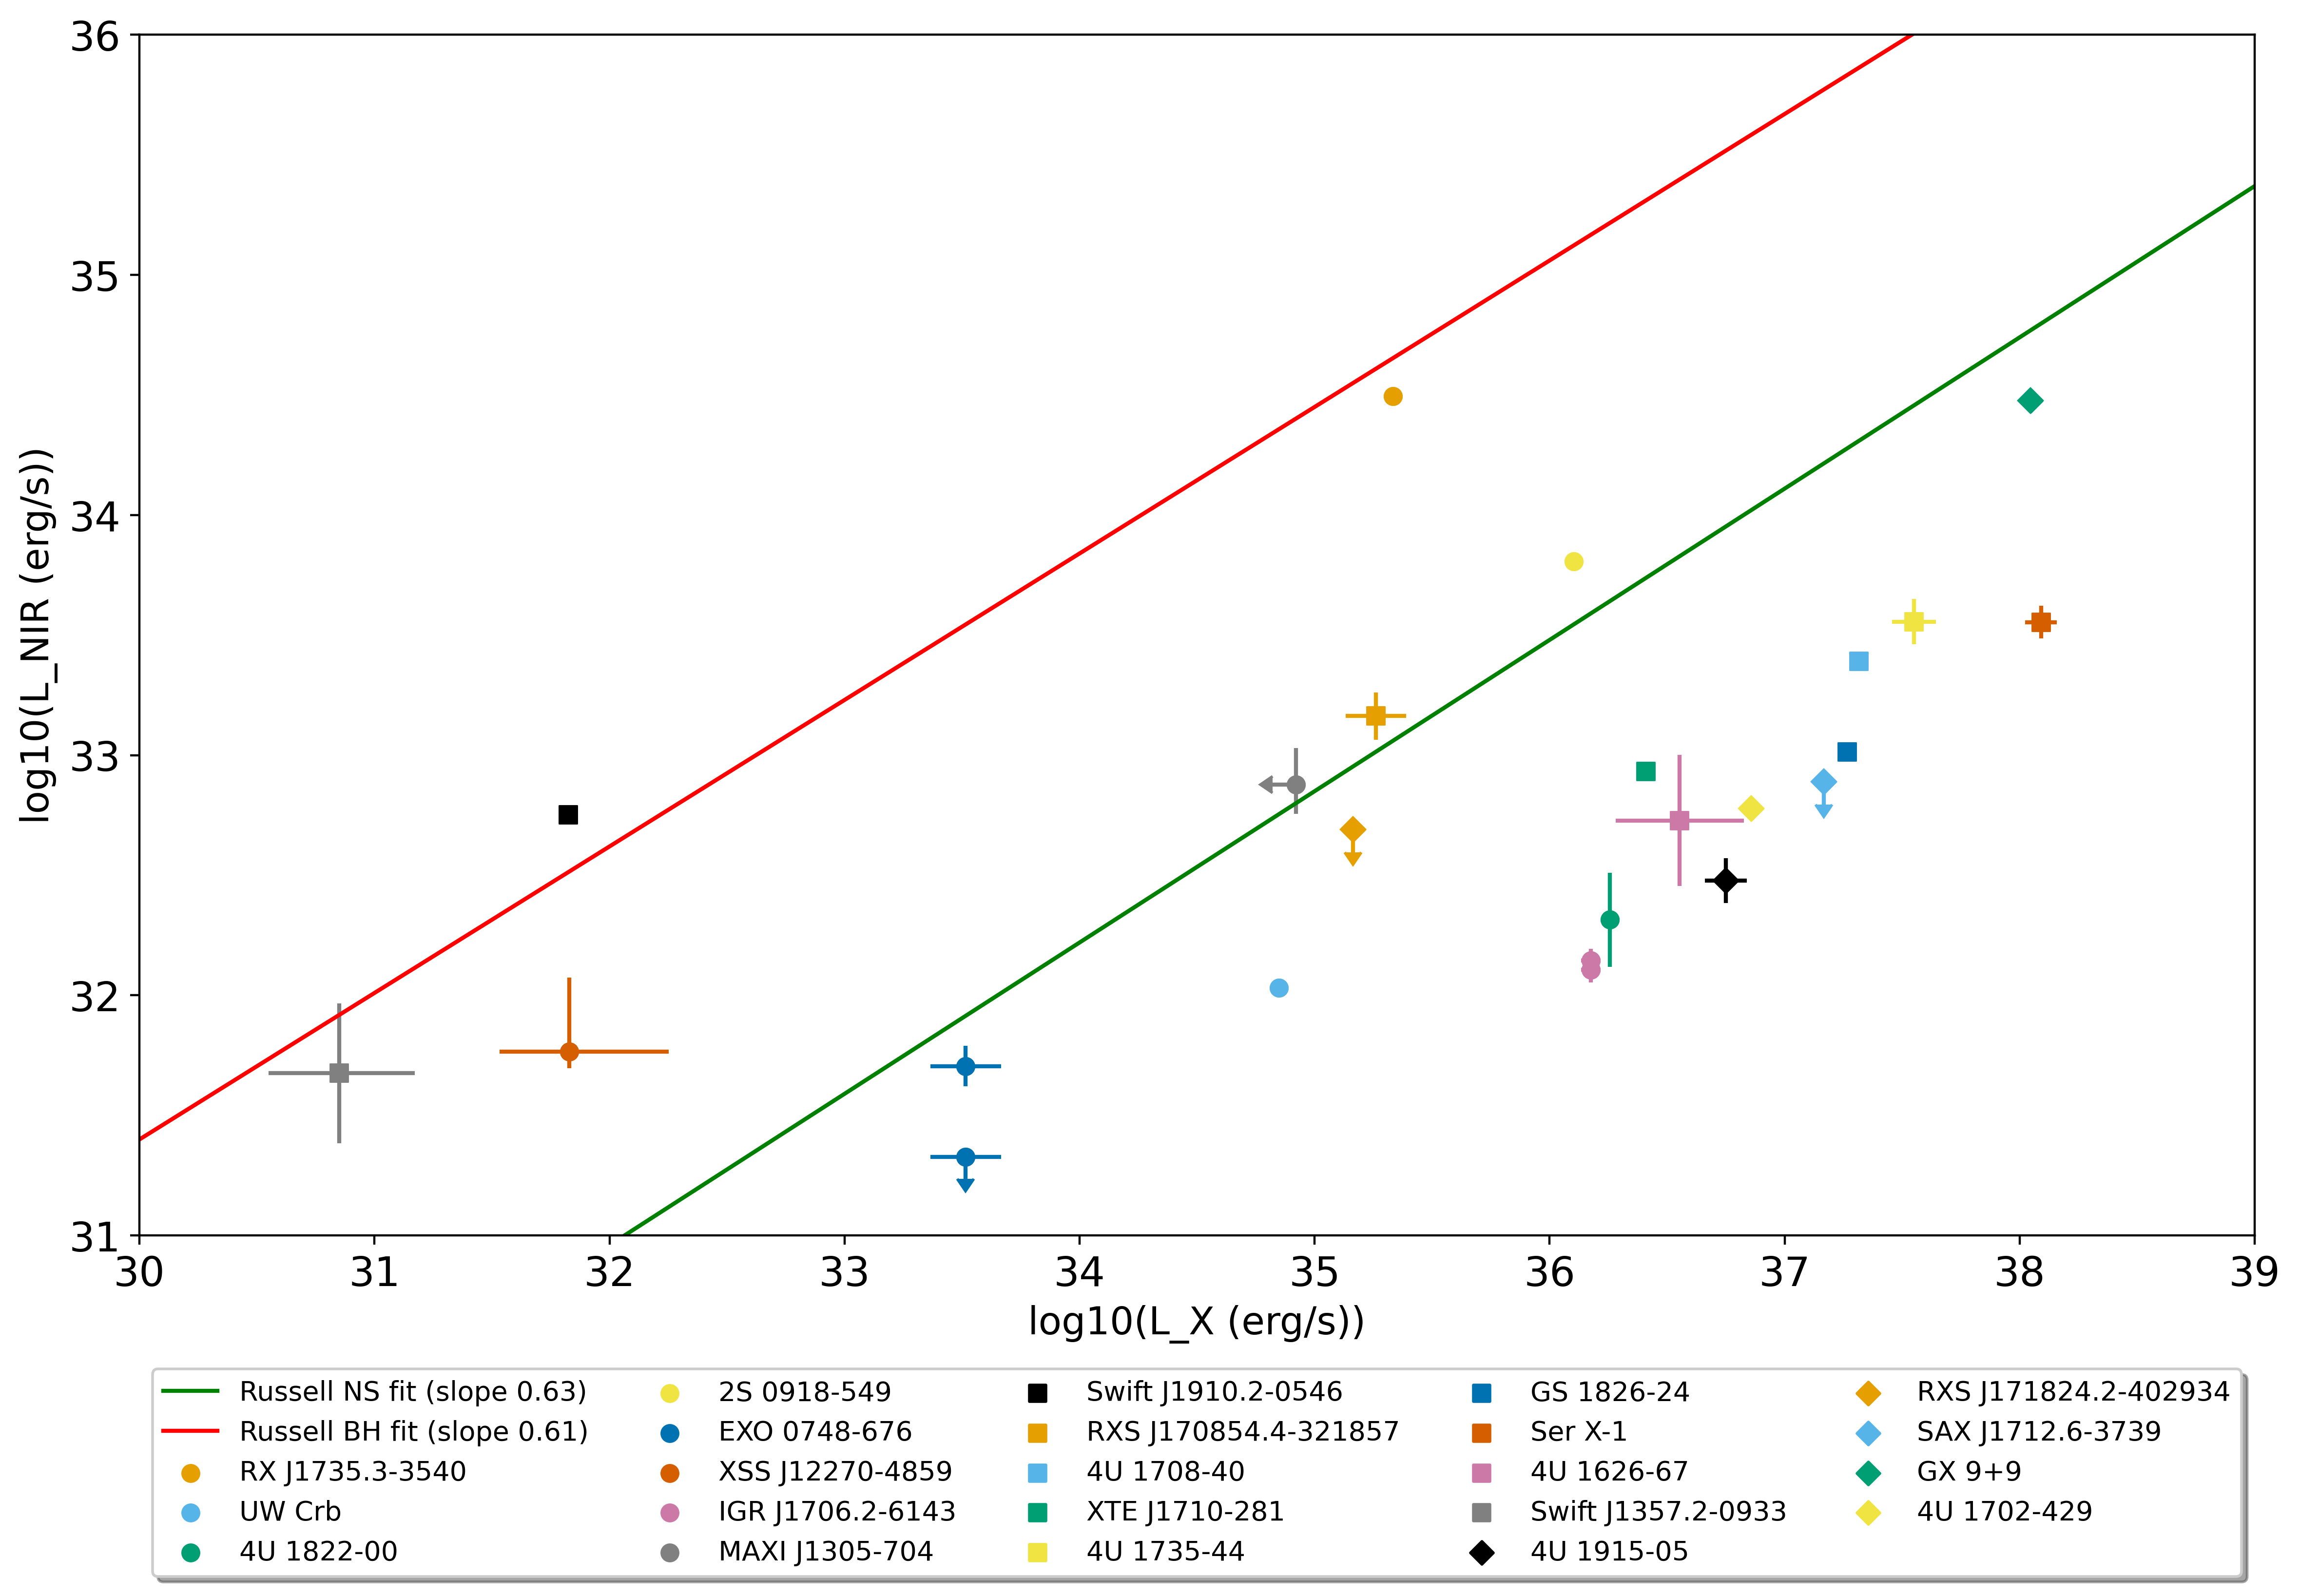

In [6]:
def plotfunc_scatter(ax, tbl, color, shape, label): 
    
    # Remove underscore from labels
    label = label.replace('_', ' ')
    # Plot regular data points 
    ax.scatter(tbl['log_L_X'], tbl['log_L_NIR'], label=label, c=color, marker=shape, zorder=10) 
    ax.errorbar(tbl['log_L_X'], tbl['log_L_NIR'], yerr=[[tbl['log_L_NIR_errlow']], [tbl['log_L_NIR_errup']]], xerr=[[tbl['log_L_X_errlow']], [tbl['log_L_X_errup']]], marker=shape, fmt='o', color=color)

    # Plot points with only upplim on NIR luminosity
    ax.scatter(tbl['log_L_X'], tbl['log_L_NIR_upplim'], label=label, c=color, marker=shape, zorder=10)      
    ax.errorbar(tbl['log_L_X'], tbl['log_L_NIR_upplim'], yerr=[tbl['log_L_NIR_upplim']*arrow_scale], xerr=[[tbl['log_L_X_errlow']], [tbl['log_L_X_errup']]], uplims = True, marker=shape, fmt='o', color=color)

    # Plot points with only upplim on X-ray luminosity
    ax.scatter(tbl['log_L_X_upplim'], tbl['log_L_NIR'], label=label, c=color, marker=shape, zorder=10)         
    ax.errorbar(tbl['log_L_X_upplim'], tbl['log_L_NIR'], yerr=[[tbl['log_L_NIR_errlow']], tbl[['log_L_NIR_errup']]], xerr=[tbl['log_L_X_upplim']*arrow_scale], xuplims = True, marker=shape, fmt='o', color=color)

    # Plot points with upplims on X-ray luminosity and NIR luminosity
    ax.scatter(tbl['log_L_X_upplim'], tbl['log_L_NIR_upplim'], label=label, c=color, marker=shape, zorder=10)         
    ax.errorbar(tbl['log_L_X_upplim'], tbl['log_L_NIR_upplim'], yerr=[tbl['log_L_NIR_upplim']*arrow_scale], xerr=[tbl['log_L_X_upplim']*arrow_scale], uplims=True, xuplims=True, marker=shape,fmt='o', color=color)





    
fig, ax = plt.subplots(figsize = (14, 8), dpi=400)
xrange= np.logspace(29, 41, num=10)
y = 10**10.8 * xrange**(0.63)
ax.plot(np.log10(xrange), np.log10(y), c='g', label='Russell NS fit (slope 0.63)')
y_bh = 10**13.1 * xrange**0.61
ax.plot(np.log10(xrange), np.log10(y_bh), c='r', label='Russell BH fit (slope 0.61)')
markers = ['o', 's', 'D', 'X', '*']
colors = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", 'grey']
options = np.array(np.meshgrid(markers, colors)).T.reshape(-1,2)
# print(options)

arrow_scale = 0.2 / np.log(10) / 30


i = 0
last_source = 'first'
for n, s in enumerate(tbl['Source']):

    # exclude not plotted sources from legend
    if np.isnan(tbl.iloc[n]['L_NIR']) and np.isnan(tbl.iloc[n]['L_NIR_upplim']) or np.isnan(tbl.iloc[n]['L_X']) and np.isnan(tbl.iloc[n]['L_X_upplim']):
        continue
        
    # every source gets a new shape-color combination
    if s != last_source: 
        i +=1
    shape = options[i][0]
    color = options[i][1]
    last_source = s
    
    # scatter plot the data for which luminosites are available
    try: 
        plotfunc_scatter(ax, tbl.iloc[n], color, shape, s)
    except:
        continue
        
ax.set_xlabel('log10(L_X (erg/s))', fontsize=14)
ax.set_ylabel('log10(L_NIR (erg/s))', fontsize=14)
ax.set_xlim(30, 39)
ax.set_ylim(31, 36)
ax.tick_params(axis='both', labelsize=15)

# remove duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
plt.show()

In [7]:
""" 
De-redden the calibrated FourStar magnitudes and the upper limit
using the method as in 
https://ui.adsabs.harvard.edu/abs/2010MNRAS.404.1591D
and the relations of
https://adsabs.harvard.edu/full/1995A%26A...293..889P
and
https://adsabs.harvard.edu/full/1985ApJ...288..618R/0000620.000.html%EF%BF%BD%C3%9C%EF%BF%BD%C3%9C
""" 
def deredden(nH, nH_err, mag, band, dereddened):
    print(dereddened)
    if dereddened:
        return mag
    else:
        # Calculate the optical extinction from the hydrogen column density
        Av = nH / (1.79*10**(21))
        Av_err = Av * np.sqrt((nH_err/nH)**2 + (0.03/1.79)**2)

        # Translate visual extinction to infrared extinction in the used filter
        if band == 'J':
            A = 0.282 * Av
            A_err = 0.282 * Av_err
        elif band == 'H':
            A = 0.175 * Av
            A_err = 0.175 * Av_err
        elif band == 'Ks':
            A = 0.112 * Av
            A_err = 0.112 * Av_err

        # Deredden the calibrated magnitudes of all detected counterparts
        mag_dered = mag - A

        return mag_dered

In [8]:
def calc_flux(upplim, band):
    """ 
    Calculate flux density based on AB magnitude system
    using     m_AB = -2.5 log10(F_nu) - 48.60 
    and       F_lamb = F_nu * c / lamb_eff
    and convert this flux density to flux. 
    """ 
    
    band = band.strip() # remove accidental whitespace     
    
    # Calculate flux density 
    if band == 'J':
        W_eff = 2214.62 # A
        l_eff = 12287.26 # A
    elif band == 'H':
        W_eff = 2769.45 # A 
        l_eff = 16039.55 # A
    elif band == 'Ks':
        W_eff = 3163.40 # A
        l_eff = 21315.89 # A

    c = 2.9979e18 # A/s

    F_nu = 10**(-(upplim+48.60)/2.5) # erg/s/cm2/Hz   
    F_lamb = F_nu * c / l_eff**2 # erg/s/cm2/A
    Flux = W_eff * F_lamb 

    return Flux



In [9]:
# TODO determine luminosities based on flux and distance
def luminosity(flux, d, lum):
    if np.isnan(lum):
        d_cm = 3.08567758128e21 * float(d) 
        L = 4 * np.pi * d_cm**2 * flux

        return L
    else:
        return lum

def luminosity_error(flux, flux_error, d, d_error, L):
    L_err = np.sqrt((flux_error/flux)**2 + 2*(d_error/float(d))**2) * L

    return L_err

In [10]:
# Load in data
extra_tbl = pd.read_csv('FSRED Mags - ExtraSources.csv')
extra_tbl = extra_tbl[extra_tbl['Band']==band] 

In [11]:
# Dereden magnitudes and upper limit
extra_tbl['mag_dered'] = extra_tbl.apply(lambda x: deredden(x['nH_heasarc'], 0, x['Magnitude '], x['Band'], x['Corrected_nH']), axis=1)
extra_tbl['mag_uplim_dered'] = extra_tbl.apply(lambda x: deredden(x['nH_heasarc'], 0, x['Magnitude_upplim'], x['Band'], x['Corrected_nH']), axis=1)

# Determine luminosities 
extra_tbl['F_NIR'] = extra_tbl.apply(lambda x: calc_flux(x['mag_dered'], x['Band']), axis=1)
extra_tbl['L_NIR'] = extra_tbl.apply(lambda x: luminosity(x['F_NIR'], x['d'], np.nan), axis=1)
extra_tbl['L_X'] = extra_tbl.apply(lambda x: luminosity(x['X-ray flux'], x['d'], x['X-ray luminosity']), axis=1)
extra_tbl['L_NIR_errup'] = extra_tbl.apply(lambda x: luminosity_error(x['F_NIR'], 0, x['d'], x['d_errup'], x['L_NIR']), axis=1)
extra_tbl['L_NIR_errlow'] = extra_tbl.apply(lambda x: luminosity_error(x['F_NIR'], 0, x['d'], x['d_errlow'], x['L_NIR']), axis=1)
extra_tbl['L_X_errup'] = extra_tbl.apply(lambda x: luminosity_error(x['X-ray flux'], x['X-ray_high'], x['d'], x['d_errup'], x['L_X']), axis=1)
extra_tbl['L_X_errlow'] = extra_tbl.apply(lambda x: luminosity_error(x['X-ray flux'], x['X-ray_low'], x['d'], x['d_errlow'], x['L_X']), axis=1)

# Determine upper limits on luminosities where needed
extra_tbl['F_NIR_upplim'] = extra_tbl.apply(lambda x: calc_flux(x['mag_uplim_dered'], x['Band']), axis=1)
extra_tbl['L_NIR_upplim'] = extra_tbl.apply(lambda x: luminosity(x['F_NIR_upplim'], x['d'], np.nan), axis=1)
# extra_tbl['L_X_upplim'] = extra_tbl.apply(lambda x: luminosity(x['Xray_upplim'], x['Distance (kpc)']), axis=1)

True
True
True
True
True
True
True
True
False
False
False
False
False
False
True
True
True
True
True
True
True
True
False
False
False
False
False
False


C:\Users\Iris Reitsma\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


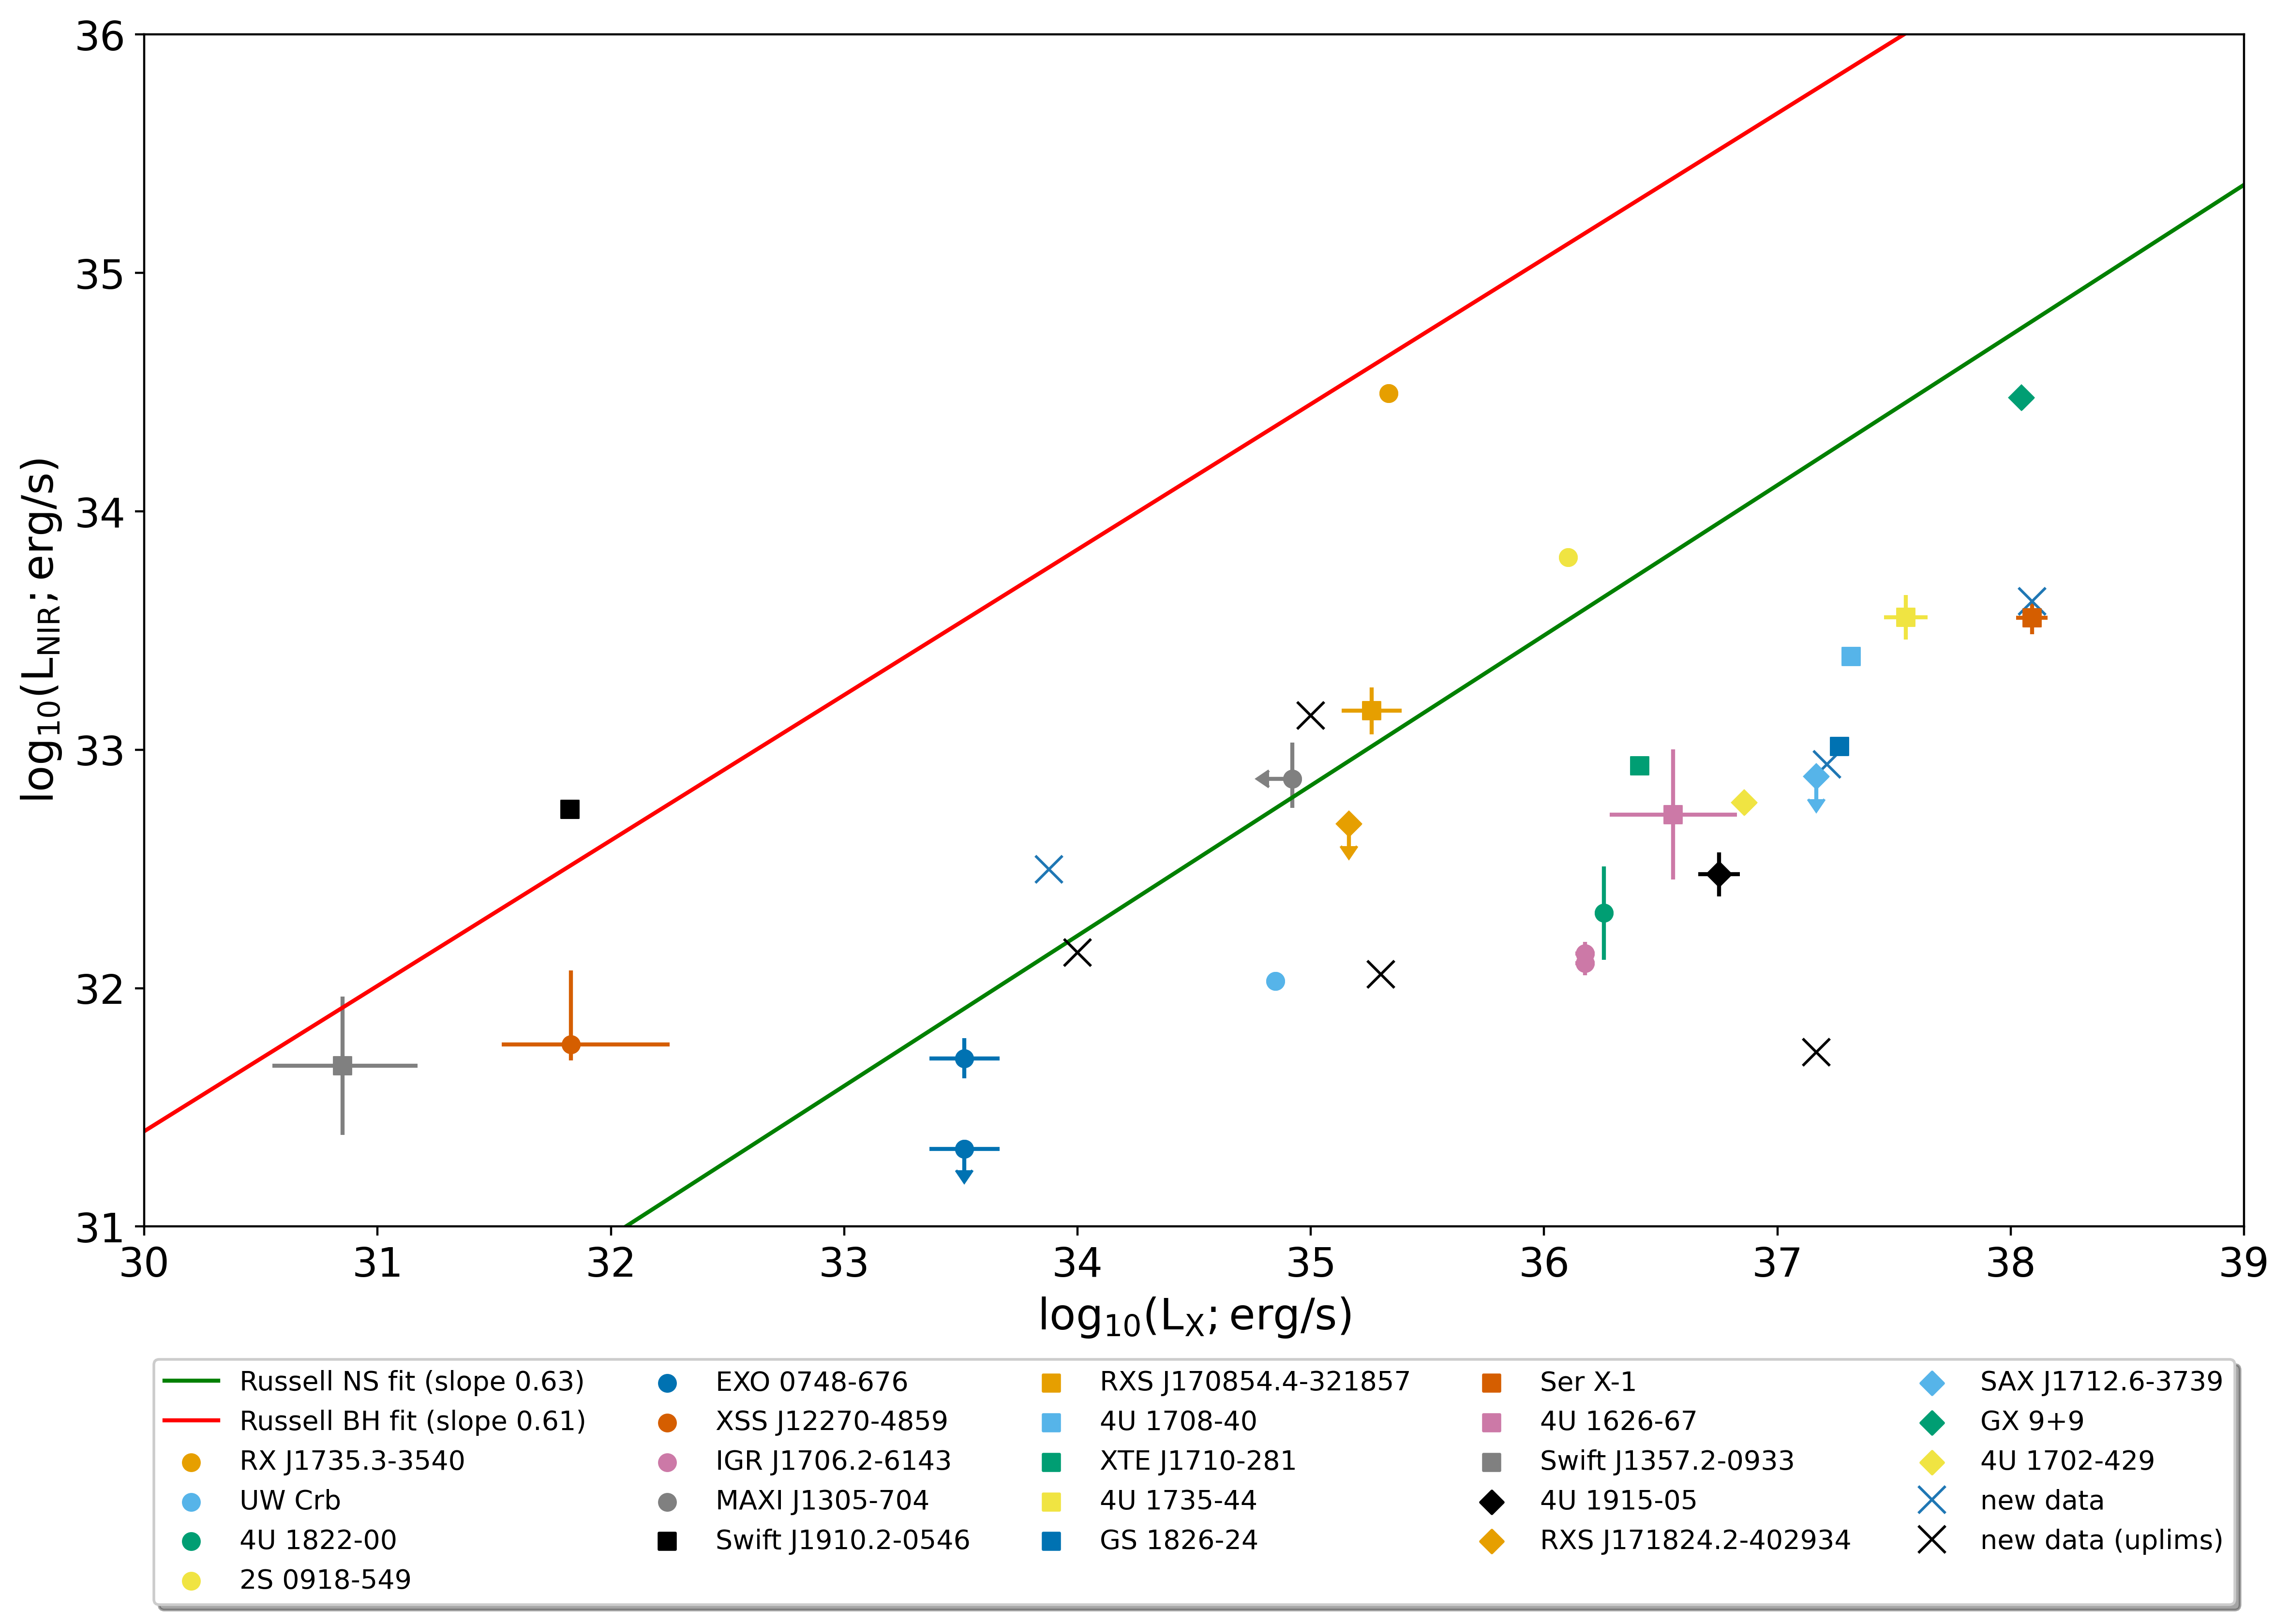

In [12]:
def plotfunc_scatter(ax, tbl, color, shape, label): 
    
    # Remove underscore from labels
    label = label.replace('_', ' ')
    # Plot regular data points 
    ax.scatter(tbl['log_L_X'], tbl['log_L_NIR'], label=label, c=color, marker=shape, zorder=10) 
    ax.errorbar(tbl['log_L_X'], tbl['log_L_NIR'], yerr=[[tbl['log_L_NIR_errlow']], [tbl['log_L_NIR_errup']]], xerr=[[tbl['log_L_X_errlow']], [tbl['log_L_X_errup']]], marker=shape, fmt='o', color=color)

    # Plot points with only upplim on NIR luminosity
    ax.scatter(tbl['log_L_X'], tbl['log_L_NIR_upplim'], label=label, c=color, marker=shape, zorder=10)      
    ax.errorbar(tbl['log_L_X'], tbl['log_L_NIR_upplim'], yerr=[tbl['log_L_NIR_upplim']*arrow_scale], xerr=[[tbl['log_L_X_errlow']], [tbl['log_L_X_errup']]], uplims = True, marker=shape, fmt='o', color=color)

    # Plot points with only upplim on X-ray luminosity
    ax.scatter(tbl['log_L_X_upplim'], tbl['log_L_NIR'], label=label, c=color, marker=shape, zorder=10)         
    ax.errorbar(tbl['log_L_X_upplim'], tbl['log_L_NIR'], yerr=[[tbl['log_L_NIR_errlow']], tbl[['log_L_NIR_errup']]], xerr=[tbl['log_L_X_upplim']*arrow_scale], xuplims = True, marker=shape, fmt='o', color=color)

    # Plot points with upplims on X-ray luminosity and NIR luminosity
    ax.scatter(tbl['log_L_X_upplim'], tbl['log_L_NIR_upplim'], label=label, c=color, marker=shape, zorder=10)         
    ax.errorbar(tbl['log_L_X_upplim'], tbl['log_L_NIR_upplim'], yerr=[tbl['log_L_NIR_upplim']*arrow_scale], xerr=[tbl['log_L_X_upplim']*arrow_scale], uplims=True, xuplims=True, marker=shape,fmt='o', color=color)





    
fig, ax = plt.subplots(figsize = (14, 8), dpi=400)
xrange= np.logspace(29, 41, num=10)
y = 10**10.8 * xrange**(0.63)
ax.plot(np.log10(xrange), np.log10(y), c='g', label='Russell NS fit (slope 0.63)')
y_bh = 10**13.1 * xrange**0.61
ax.plot(np.log10(xrange), np.log10(y_bh), c='r', label='Russell BH fit (slope 0.61)')
markers = ['o', 's', 'D', 'X', '*']
colors = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", 'grey']
options = np.array(np.meshgrid(markers, colors)).T.reshape(-1,2)
# print(options)

arrow_scale = 0.2 / np.log(10) / 30

i = 0
last_source = 'first'
for n, s in enumerate(tbl['Source']):

    # exclude not plotted sources from legend
    if np.isnan(tbl.iloc[n]['L_NIR']) and np.isnan(tbl.iloc[n]['L_NIR_upplim']) or np.isnan(tbl.iloc[n]['L_X']) and np.isnan(tbl.iloc[n]['L_X_upplim']):
        continue
        
    # every source gets a new shape-color combination
    if s != last_source: 
        i +=1
    shape = options[i][0]
    color = options[i][1]
    last_source = s
    
    # scatter plot the data for which luminosites are available
    try: 
        plotfunc_scatter(ax, tbl.iloc[n], color, shape, s)
    except:
        continue
    
# plot errorbar
# ax.errorbar(32, 35, yerr=[[NIR_std_low], [NIR_std_up]], xerr=[[X_std_low] , [X_std_up]], fmt='o', ms=5, color='k')

# # Plot regular extra data points 
# ax.errorbar(extra_tbl['L_X'], extra_tbl['L_NIR'], yerr=[extra_tbl['L_NIR_errlow'], extra_tbl['L_NIR_errup']], xerr=[extra_tbl['L_X_errlow'], extra_tbl['L_X_errup']], label='new data', fmt='o', ms=3)

# # Plot extra points with only upplim on NIR luminosity
# ax.errorbar(extra_tbl['L_X'], extra_tbl['L_NIR_upplim'], yerr=extra_tbl['L_NIR_upplim']*arrow_scale, xerr=[extra_tbl['L_X_errlow'], extra_tbl['L_X_errup']], uplims =[True for i in range(len(extra_tbl))], fmt='o', ms=3, color='k', label='new data (uplims)')

# Plot regular extra data points 
ax.errorbar(np.log10(extra_tbl['L_X']), np.log10(extra_tbl['L_NIR']), label='new data', fmt='x', ms=10)

# Plot extra points with only upplim on NIR luminosity
ax.errorbar(np.log10(extra_tbl['L_X']), np.log10(extra_tbl['L_NIR_upplim']), uplims =[True for i in range(len(extra_tbl))], fmt='x', ms=10, color='k', label='new data (uplims)')


ax.set_xlabel(r'$\mathrm{log_{10}(L_{X}; erg/s)}$', fontsize=16)
ax.set_ylabel(r'$\mathrm{log_{10}(L_{NIR}; erg/s)}$', fontsize=16)
ax.set_xlim(30, 39)
ax.set_ylim(31, 36)
ax.tick_params(axis='both', labelsize=15)

# remove duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
plt.show()

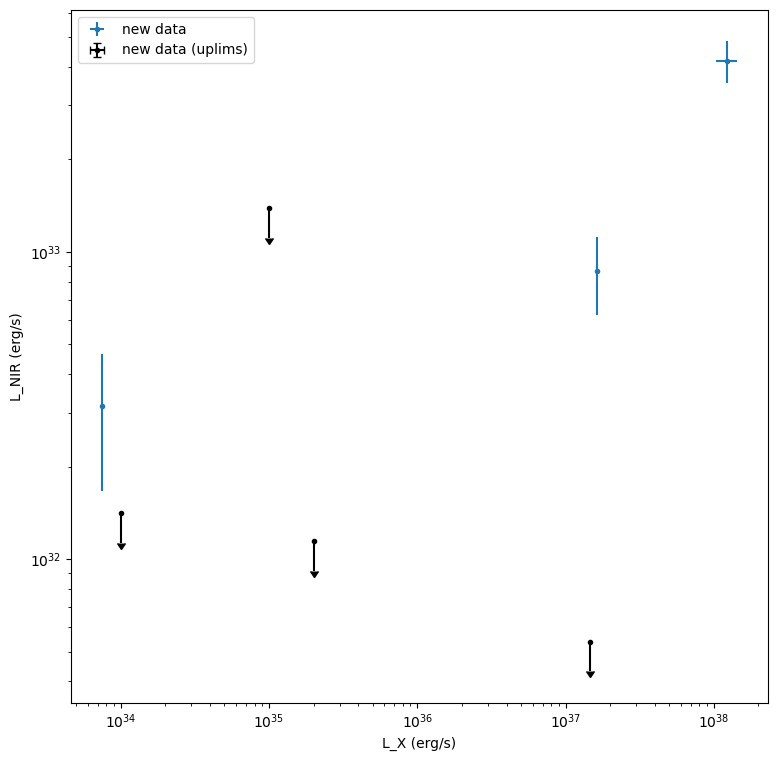

In [13]:


fig, ax = plt.subplots(figsize = (9, 9))
# xrange= np.logspace(29, 41, num=10)
# y = 10**10.8 * xrange**(0.63)
# ax.plot(xrange, y, c='g', label='Russell NS fit (slope 0.63)')
# y_bh = 10**13.1 * xrange**0.61
# ax.plot(xrange, y_bh, c='r', label='Russell BH fit (slope 0.61)')

arrow_scale = 0.2

# Plot regular data points 
ax.errorbar(extra_tbl['L_X'], extra_tbl['L_NIR'], yerr=[extra_tbl['L_NIR_errlow'], extra_tbl['L_NIR_errup']], xerr=[extra_tbl['L_X_errlow'], extra_tbl['L_X_errup']], label='new data', fmt='o', ms=3)

# Plot points with only upplim on NIR luminosity
ax.errorbar(extra_tbl['L_X'], extra_tbl['L_NIR_upplim'], yerr=extra_tbl['L_NIR_upplim']*arrow_scale, xerr=[extra_tbl['L_X_errlow'], extra_tbl['L_X_errup']], uplims =[True for i in range(len(extra_tbl))], fmt='o', ms=3, color='k', label='new data (uplims)')

# # Plot points with only upplim on X-ray luminosity
# ax.errorbar(extra_tbl['L_X_upplim'], extra_tbl['L_NIR'], yerr=[extra_tbl['L_NIR_errlow'], extra_tbl['L_NIR_errup']], xerr=extra_tbl['L_X_upplim']*arrow_scale, xuplims =[True for i in range(len(extra_tbl))], fmt='o', ms=3, color='k')

# # Plot points with upplims on X-ray luminosity and NIR luminosity
# ax.errorbar(extra_tbl['L_X_upplim'], extra_tbl['L_NIR_upplim'], yerr=extra_tbl['L_NIR_upplim']*arrow_scale, xerr=extra_tbl['L_X_upplim']*arrow_scale, uplims=[True for i in range(len(extra_tbl))], xuplims =[True for i in range(len(extra_tbl))], fmt='o', ms=3, color='k')



ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('L_X (erg/s)')
ax.set_ylabel('L_NIR (erg/s)')
# ax.set_xlim(10e29, 10e39)
# ax.set_ylim(10e28, 10e38)

# for i, row in tbl.iterrows():
#     ax.annotate(row['Source'], (tbl['L_X'][i], tbl['L_NIR'][i]))

plt.legend()
plt.show()

# TODO Add nice labels for sources

In [14]:
trial = extra_tbl.iloc[1]['Corrected_nH']
print(trial)
import math
if np.isnan(trial):
    print('oi')

True


In [15]:

    
display(extra_tbl)

,Source,Band,Date,Magnitude,Magnitude_err,Magnitude_upplim,Corrected_nH,Literature NIR,Telescope,nH,...,mag_uplim_dered,F_NIR,L_NIR,L_X,L_NIR_errup,L_NIR_errlow,L_X_errup,L_X_errlow,F_NIR_upplim,L_NIR_upplim
0,4U_1556-60,J,13-5-2011,17.83,0.06,NaN,True,Revnivtsev+2013,IRSF,NaN,...,NaN,1.178165e-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4U_1708-40,J,13-5-2011,18.84,0.18,NaN,True,Revnivtsev+2013,IRSF,3.000000e+22,...,NaN,4.647359e-14,8.688349e+32,1.626486e+37,2.457436e+32,2.457436e+32,NaN,NaN,NaN,NaN
6,AXJ_165901-4208,J,13-5-2011,18.33,0.06,NaN,True,Revnivtsev+2013,IRSF,NaN,...,NaN,7.433721e-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,IGR_J16287-5021,J,13-5-2011,16.84,0.04,NaN,True,Revnivtsev+2013,IRSF,2.600000e+22,...,NaN,2.932286e-13,3.157619e+32,7.537920e+33,1.488516e+32,1.488516e+32,NaN,NaN,NaN,NaN
12,IGR_J17350-2045,J,13-5-2011,15.35,0.06,NaN,True,Revnivtsev+2013,IRSF,NaN,...,NaN,1.156661e-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,AX_J171922-3703,J,13-5-2011,NaN,NaN,19.5,True,Revnivtsev+2013,IRSF,NaN,...,19.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.530500e-14,NaN
18,SAX_J1712.6-3739,J,13-5-2011,NaN,NaN,20.6,True,Revnivtsev+2013,IRSF,NaN,...,20.600000,NaN,NaN,1.465707e+37,NaN,NaN,NaN,NaN,9.187689e-15,5.386582e+31
21,4U_1705-32,J,13-5-2011,NaN,NaN,20.8,True,Revnivtsev+2013,IRSF,NaN,...,20.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.641986e-15,NaN
24,XTE_J1637−498,J,20-9-2008,14.80,0.09,NaN,False,Curran+2011,ISAAC,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,IGR_J17379−3747,J,2-10-2008,18.30,0.10,NaN,False,Curran+2011,ISAAC,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
print(mag_cal)
print(mag_dered)
print(Flux)
print(L)

NameError: name 'mag_cal' is not defined